# **Lab 6b - Explainable and Trustworthy AI**


---



**Teaching Assistant**: *Salvatore Greco*

**DISCLAIMER**: *This lab contains examples of offensive language*.

## **Lab 6b:** Explainable Natural Language Processing (NLP) 

In this lab, you will use *post-hoc* and *feature-based* explainability techniques to explain the **binary toxicity prediction BERT classifier** trained in lab 6a. <br>
You will also use a library to visualize the internal attention values in the model.

Firstly, you need to install these libraries. Run the next cell to install it (uncomment the lines if you need to install them).


In [1]:
#!pip install transformers
#!pip install datasets
#!pip install accelerate -U

In [2]:
#!pip install shap

In [3]:
#!pip install -U ferret-xai

In [4]:
#!pip install bertviz
#!pip install jupyterlab
#!pip install ipywidgets

Run the next cell to import the required libraries for this lab.

In [5]:
# Import the required libraries for this lab
from datasets import load_dataset

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline, utils
import transformers


import pandas as pd

import shap
from ferret import Benchmark

Run the following command to check GPU utilization, memory usage, and availability.
If the command outputs information about your GPU, it means the GPU is available.
In contrast, the command returns an error or no information, it indicates that the GPU might not be available or there is an issue.

Note that a GPU is highly recommended for training (fine-tune) transformer models.<br> However, you can also complete this lab without GPUs since you have to perform inference and explanations only.

In [6]:
!nvidia-smi

Thu May  9 19:41:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB           On  | 00000000:D8:00.0 Off |                    0 |
| N/A   39C    P0              24W / 250W |      4MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

---

## **Exercise 1: Load the dataset and model**

### **Exercise 1.1**: Load dataset

Firstly, you will load the dataset using the HuggingFace [Datasets](https://huggingface.co/docs/datasets/index) library. You will load the same dataset of publicly available Wikipedia comments annotated for several aspects of toxicity ([Jigsaw Toxic Comments](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)).

Remember that you can load the dataset using the [load_dataset](https://huggingface.co/docs/datasets/loading) function of the `Datasets` transformers library.

The dataset of Wikipedia comments annotated for toxicity is available on HugginFace [Here](https://huggingface.co/datasets/google/jigsaw_toxicity_pred).<br> However, in this particular case, you must also have the files in a local folder and specify that folder in the `load_dataset` function.

Make sure you have a local folder with the following tree structure:
```
.
└── jigsaw_toxicity_pred/
    ├── test.csv
    ├── test_labels.csv
    └── test_pred.csv
```

You can only load the **test** set for this Lab. Therefore, you can also avoid uploading the training set.
If you only upload the test set, make sure to specify it when loading the dataset.

Replace `None` with your code.

In [7]:
#!ls

In [8]:
#!unzip -o jigsaw_toxicity_pred.zip

In [9]:
#### START CODE HERE (Replace None with your code) ####

# Load the jigsaw toxicity prediction dataset
dataset = load_dataset("google/jigsaw_toxicity_pred", data_dir="jigsaw_toxicity_pred", split="test")

#### END CODE HERE ####

/home/students/s289159/.conda/envs/prova-env/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for google/jigsaw_toxicity_pred contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/jigsaw_toxicity_pred
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [10]:
dataset

Dataset({
    features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    num_rows: 63978
})

In [11]:
# Dictionary that maps the label id to the label name
id2label = {0: "Non-Toxic", 1: "Toxic"} 

# Dictionary that maps the label name to the label id
label2id = {"Non-Toxic": 0, "Toxic": 1}

label_names = ['Non-Toxic', 'Toxic']

### **Exercise 1.2**: Load the predicted labels

In the `test_pred.csv` file, you are also provided with the **labels predicted on the test set** by the fine-tuned BERT model.

Now load the predicted labels into a Pandas DataFrame.

Replace `None` with your code.

In [12]:
#### START CODE HERE (Replace None with your code) ####

df_test_pred = pd.read_csv("jigsaw_toxicity_pred/test_pred.csv")

#### END CODE HERE ####

In [13]:
df_test_pred.head()

,Unnamed: 0,non_toxic_prob,toxic_prob,pred_label
0,0,0.999795,0.000205,Non-Toxic
1,1,0.126119,0.873881,Toxic
2,2,0.995019,0.004981,Non-Toxic
3,3,0.999784,0.000216,Non-Toxic
4,4,0.999805,0.000195,Non-Toxic


### **Exercise 1.3**: Add the predicted columns to the dataset

Add to the `dataset` a new column `'pred_label'` containing the predicted label ids.

You can find the method to use in the [Datasets features](https://huggingface.co/docs/datasets/about_dataset_features).

In [14]:
#### START CODE HERE (~ 2 lines) ####

predicted_labels = df_test_pred.pred_label.tolist()
dataset = dataset.add_column('pred_label', predicted_labels)

#### END CODE HERE ####

In [15]:
dataset

Dataset({
    features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'pred_label'],
    num_rows: 63978
})

### **Exercise 1.4**: Select correctly and misclassified toxic comments

Select into:
- `toxic_comments_dataset`: All the texts predicted as toxic.
- `misclassified_toxic_comments_dataset`: All the texts that were non-toxic but are predicted as toxic (i.e., misclassified toxic comments).
- `correctly_classified_toxic_comments_dataset`: All the texts that were toxic and are predicted as toxic (i.e., correctly classified toxic comments).

You can find the method to use in the [Datasets process](https://huggingface.co/docs/datasets/process) methods.

Replace `None` with your code.

In [16]:
#### START CODE HERE (Replace None with your code) ####

toxic_comments_dataset = dataset.filter(lambda example: example["pred_label"] == "Toxic")
misclassified_toxic_comments_dataset = dataset.filter(lambda example: example["pred_label"] == "Toxic" and example["toxic"] == 0)
correctly_classified_toxic_comments_dataset = dataset.filter(lambda example: example["pred_label"] == "Toxic" and example["toxic"] == 1)

#### END CODE HERE ####

In [17]:
misclassified_toxic_comments_dataset

Dataset({
    features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'pred_label'],
    num_rows: 4226
})

In [45]:
correctly_classified_toxic_comments_dataset

Dataset({
    features: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'pred_label'],
    num_rows: 5421
})

In [18]:
text_id = 0

print(f"Original label: {id2label[misclassified_toxic_comments_dataset['toxic'][text_id]]}")
print(f"Priginal label: {misclassified_toxic_comments_dataset['pred_label'][text_id]}")

Original label: Non-Toxic
Priginal label: Toxic


In [19]:
text_id = 0

print(f"Original label: {id2label[correctly_classified_toxic_comments_dataset['toxic'][text_id]]}")
print(f"Priginal label: {correctly_classified_toxic_comments_dataset['pred_label'][text_id]}")

Original label: Toxic
Priginal label: Toxic


### **Exercise 1.5**: Load the model and tokenizer

Load the fine-tuned BERT model (available at `"grecosalvatore/binary-toxicity-BERT-xai-course"`) and the tokenizer. <br>
Set the correct maximum sequence length (i.e., 256).

Replace `None` with your code.

In [20]:
#### START CODE HERE (Replace None with your code) ####

model_name = "grecosalvatore/binary-toxicity-BERT-xai-course"
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True, max_length=256)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#### END CODE HERE ####

/home/students/s289159/.conda/envs/prova-env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### **Exercise 1.6**: Make predictions

Write a new input text, and use the model to **predict** the **toxicity label** for that text.

In [21]:
#### START CODE HERE ####

pipe = pipeline("text-classification", tokenizer=tokenizer, model="grecosalvatore/binary-toxicity-BERT-xai-course", truncation=True,  return_all_scores=False)

your_input_text = "The sentence 'I hate you' contains the word hate"

pipe(your_input_text)

/home/students/s289159/.conda/envs/prova-env/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': 'Toxic', 'score': 0.9839322566986084}]

---

## **Exercise 2: Local-explanations with SHAP**

[SHAP](https://arxiv.org/pdf/1705.07874) (SHapley Additive exPlanations) is a framework for interpreting machine learning model predictions. It uses game theory concepts to allocate feature contributions to individual predictions fairly, explaining their impact positively or negatively. This method provides a consistent measure of feature importance across various models.

Firstly, you will use SHAP to explain the BERT model already fine-tuned for binary toxicity prediction.

The official SHAP implementation is available at the following [GitHub](https://github.com/shap/shap) repository and [Docs](https://shap.readthedocs.io/en/latest/). 



### **Exercise 2.1**: Compute the Local-explanations of correctly classified examples with SHAP

Perform and visualize the **local-explanations** of the first 5 comments **correctly classified** as toxic using SHAP.

In [22]:
#### START CODE HERE ####

shap_explainer = shap.Explainer(pipe)

In [23]:
correctly_classified_toxic_comments_dataset["comment_text"][:5]

['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
 'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
 ':Fuck off, you anti-semitic cunt.  |',
 "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
 '::No, he is an arrogant, self serving, immature idiot. Get it right.']

In [24]:
shap_values = shap_explainer(correctly_classified_toxic_comments_dataset["comment_text"][:5])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:30<00:11,  5.63s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:35<00:05,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [00:50<00:00,  9.11s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:05, 13.11s/it]                       


In [25]:
shap.plots.text(shap_values[:, :, "Toxic"])

### **Exercise 2.2**: Compute the Local-explanations of misclassified examples with SHAP

Now, perform and visualize the **local-explanations** of the first 5 comments **misclassified** as toxic using SHAP.


In [26]:
#### START CODE HERE ####

shap_values = shap_explainer(misclassified_toxic_comments_dataset["comment_text"][:5])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 2/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [00:38,  9.61s/it]                       


In [27]:
shap.plots.text(shap_values[:, :, "Toxic"])

---

## **Exercise 3: Global-explanations with SHAP**

SHAP is also able to provide some kind of global-explanations (or global insights) about the model by aggregating many local-explanations.

### **Exercise 3.1**: Compute the Global-explanations of correctly classified examples with SHAP

Compute and visualize the **global-explanations** by aggregating the first 25 comments **correctly classified** as toxic using SHAP.<br> Visualize it by aggregating the local score with the **mean** of the individual contributions.

***(if it takes too long, reduce the number of input sentences)***

In [28]:
#### START CODE HERE ####

shap_values = shap_explainer(correctly_classified_toxic_comments_dataset["comment_text"][:25])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 1/25 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▏        | 3/25 [00:26<02:02,  5.59s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 4/25 [00:31<01:52,  5.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 5/25 [00:47<03:02,  9.13s/it]

  0%|          | 0/420 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 6/25 [01:02<03:32, 11.16s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 7/25 [01:14<03:30, 11.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 8/25 [01:30<03:38, 12.86s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 9/25 [01:37<02:57, 11.10s/it]

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 11/25 [01:43<01:35,  6.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 13/25 [02:01<01:25,  7.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 14/25 [02:17<01:47,  9.81s/it]

  0%|          | 0/156 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 15/25 [02:23<01:27,  8.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  68%|██████▊   | 17/25 [02:41<01:06,  8.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 18/25 [02:59<01:16, 10.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 20/25 [03:18<00:49,  9.82s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 21/25 [03:34<00:46, 11.57s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 22/25 [03:42<00:31, 10.39s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 24/25 [03:51<00:07,  7.22s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 25/25 [03:59<00:00,  7.54s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 26it [04:05,  9.84s/it]                        


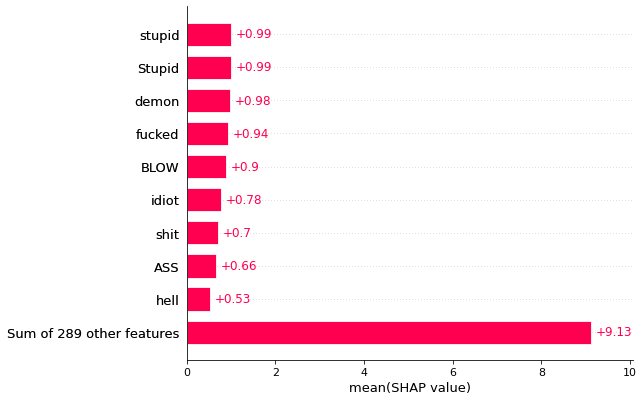

In [29]:
shap.plots.bar(shap_values[:, :, "Toxic"].mean(0))

### **Exercise 3.2**: Compute the Global-explanations of correctly classified examples with SHAP

Now, visualize the same explanation by aggregating the local score with the **sum** of the individual contributions.

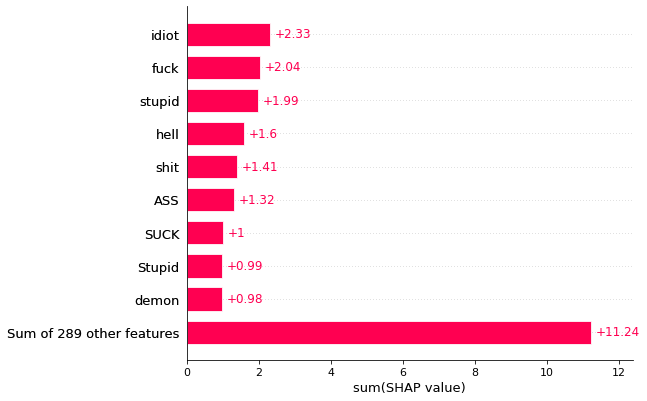

In [30]:
#### START CODE HERE ####

shap.plots.bar(shap_values[:, :, "Toxic"].sum(0))

### **Exercise 3.3**: Compute the Global-explanations of misclassified examples with SHAP

Compute and visualize the **global-explanations** by aggregating the first 25 comments **misclassified** as toxic using SHAP. 

Visualize it by aggregating the local score first with the **mean** and then with the **sum** of the individual contributions.

***(if it takes too long, reduce the number of input sentences)***

In [31]:
shap_values = shap_explainer(misclassified_toxic_comments_dataset["comment_text"][:25])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 2/25 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▍       | 6/25 [00:38<01:14,  3.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 7/25 [01:06<03:43, 12.41s/it]

  0%|          | 0/462 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▏      | 8/25 [01:17<03:22, 11.89s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  36%|███▌      | 9/25 [01:24<02:46, 10.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 10/25 [01:41<03:07, 12.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  44%|████▍     | 11/25 [02:00<03:23, 14.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 12/25 [02:18<03:20, 15.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  52%|█████▏    | 13/25 [02:33<03:05, 15.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  56%|█████▌    | 14/25 [02:51<02:57, 16.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 15/25 [03:06<02:39, 15.97s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  64%|██████▍   | 16/25 [03:21<02:21, 15.71s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 18/25 [03:47<01:34, 13.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 20/25 [04:06<00:52, 10.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  84%|████████▍ | 21/25 [04:21<00:48, 12.15s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 22/25 [04:36<00:38, 12.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▏| 23/25 [04:53<00:28, 14.03s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 24/25 [05:26<00:19, 19.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 25/25 [05:49<00:00, 20.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 26it [06:10, 15.44s/it]                        


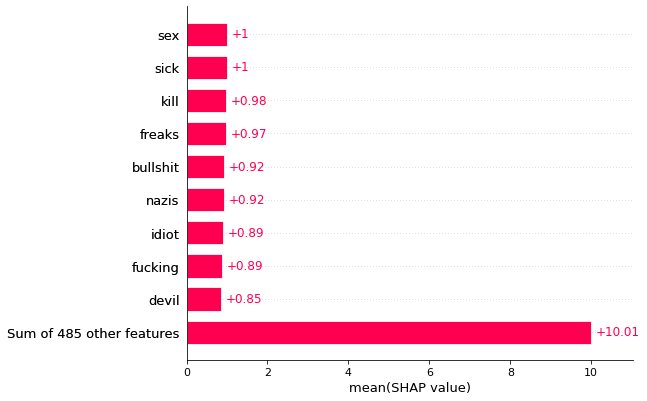

In [32]:
shap.plots.bar(shap_values[:, :, "Toxic"].mean(0))

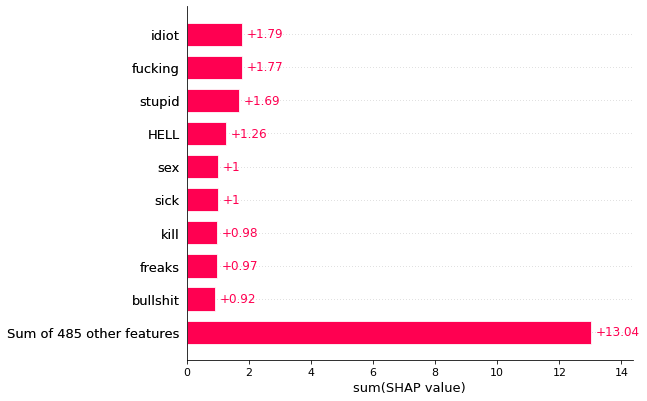

In [33]:
shap.plots.bar(shap_values[:, :, "Toxic"].sum(0))

---

## **Exercise 4: Local-explanations using Ferret**

There are several libraries that provide implementations of many XAI techniques for the NLP domain, such as [Ferret](https://github.com/g8a9/ferret), [Captum](https://github.com/pytorch/captum), [Alibi Explain](https://docs.seldon.io/projects/alibi/en/latest/).

In this exercise, you will use the [Ferret](https://github.com/g8a9/ferret) library implementation of SHAP, LIME,and Integrated Gradients techniques.

You can read the official Ferret [Docs](https://ferret.readthedocs.io/en/latest/) and [Paper](https://aclanthology.org/2023.eacl-demo.29.pdf).

In [34]:
input_text = correctly_classified_toxic_comments_dataset["comment_text"][15]
input_text

'where I feel like a man instead of an idiot'

### **Exercise 4.1**: Compute local-explanations with the SHAP, LIME, and Integrated Gradients algorithms using the Ferret library

Compute and visualize the **local-explanations** of the comment stored in the variable `input_text` using the Ferret implementation of the SHAP, LIME, and Integrated Gradients techniques.

In [35]:
#### START CODE HERE ####

ferret_explainer = Benchmark(model, tokenizer)

In [36]:
explanations = ferret_explainer.explain(input_text, target=1)

Explainer:   0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
ferret_explainer.show_table(explanations)

Token,where,i,feel,like,a,man,instead,of,an,idiot
Partition SHAP,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.99
LIME,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,-0.01,0.95
Gradient,0.05,0.04,0.10,0.05,0.03,0.05,0.07,0.03,0.10,0.35
Gradient (x Input),-0.05,-0.02,-0.04,0.01,0.01,-0.00,-0.00,-0.03,0.04,0.70
Integrated Gradient,0.07,-0.05,-0.09,0.15,0.12,-0.02,-0.18,-0.00,-0.06,0.05
Integrated Gradient (x Input),0.01,0.02,0.05,-0.04,-0.01,0.01,0.06,-0.06,0.05,0.70


---

## **Exercise 5: Visualize attention scores with BertViz**

Some techniques visualize attention in Transformer language models to provide some insights about the internal model behavior.

In this exercise, you will use [BertViz](https://github.com/jessevig/bertviz), an interactive tool for visualizing attention in Transformer language models.

You can read the demonstration [paper](https://aclanthology.org/P19-3007.pdf).

### **Exercise 5.1**: Visualize attention scores of the BERT model for an input text

Visualize the **attention scores** of BERT for the comment stored in the variable `input_text` using the BertViz library.

In [38]:
from bertviz import model_view, head_view
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

In [39]:
input_text = correctly_classified_toxic_comments_dataset["comment_text"][15]
input_text

'where I feel like a man instead of an idiot'

In [41]:
#### START CODE HERE ####

model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)

/home/students/s289159/.conda/envs/prova-env/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [42]:
# Tokenize input text
inputs = tokenizer.encode(input_text, return_tensors='pt')  

# Run model
outputs = model(inputs)  

# Retrieve attention from model outputs
attention = outputs[-1]  

# Convert input ids to token strings
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  

# Display model view
model_view(attention, tokens) 

<IPython.core.display.Javascript object>

In [43]:
sentence_a = input_text

inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt')

input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]

#sentence_b_start = token_type_ids[0].tolist().index(1)

# Batch index 0
input_id_list = input_ids[0].tolist() 

tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [44]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>